In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf
import os
from os import chdir as cd
import warnings
import cv2
import pickle
import random
from matplotlib import gridspec   
from matplotlib import cm
from scipy import interpolate
from scipy import stats, ndimage
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from tqdm import tqdm
from sklearn.decomposition import PCA
from scipy.stats import stats
import itertools
import functools
from functools import partial
from tensorflow.keras import backend as K 
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.metrics import top_k_categorical_accuracy as tCA
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import CategoricalCrossentropy, binary_crossentropy, mse
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.optimizers import Adam, RMSprop , SGD
from tensorflow.keras.layers import add, concatenate, multiply, Layer
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Concatenate, GlobalMaxPooling2D, Reshape , Lambda , Add, Multiply, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, UpSampling2D, BatchNormalization, MaxPooling2D, Flatten, GlobalAveragePooling2D, Activation, AveragePooling2D , ZeroPadding2D, SeparableConv2D, Dropout
from tensorflow.keras.models import Model, load_model , Sequential
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping , LearningRateScheduler, ModelCheckpoint, CSVLogger, Callback, ReduceLROnPlateau
warnings.filterwarnings("ignore")

In [3]:
cd("/content/drive/Shareddrives/Me")
from lrn import LRN
from f1score import macro_f1score
labels = ['Center','Edge-Loc','Edge-Ring','Loc','Near-full','Random','Scratch','none']

# **CPU Info**

In [ ]:
!cat /proc/cpuinfo

# **Preprocessing for AE**

In [ ]:
# os.chdir("/content/drive/Shareddrives/Me")
# df=pd.read_pickle("LSWMD.pkl")
# df = df.drop(['waferIndex'], axis = 1)
# def find_dim(x):
#     dim0=np.size(x,axis=0)
#     dim1=np.size(x,axis=1)
#     return dim0,dim1
# df['waferMapDim']=df.waferMap.apply(find_dim)
# # Mapping
# df['failureNum'] = df.failureType
# df['trainTestNum'] = df.trianTestLabel
# mapping_type = {'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
# mapping_traintest = {'Training':0,'Test':1}
# df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})
# # label, pattern
# tol_wafers = df.shape[0]
# df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
# df_withlabel =df_withlabel.reset_index()
# df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
# df_withpattern = df_withpattern.reset_index() 
# df_nonpattern = df[(df['failureNum']==8)]
# sub_df = df_withlabel.loc[(df_withlabel['waferMapDim'] == (33, 29)) | (df_withlabel['waferMapDim'] == (27, 25)) | (df_withlabel['waferMapDim'] == (26, 26))].reset_index(drop=True)
# sub_df['waferMap']=sub_df.waferMap.apply(lambda x: cv2.resize(x, dsize=(32,32), interpolation = cv2.INTER_NEAREST))
# sub_df.to_pickle("main3.pkl")

In [ ]:
sub_df = pd.read_pickle("main3.pkl")

In [ ]:
sub_df.head()

,index,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,150,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0
1,151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0
2,152,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0
3,153,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0
4,154,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...",533.0,lot7,[[Training]],[[none]],"(26, 26)",8,0


In [ ]:
sub_df.shape

(33173, 9)

In [ ]:
sub_df = sub_df.loc[(sub_df['failureType'] != 'Donut')]
sub_df.shape

(33164, 9)

In [ ]:
# Plotting
sw = np.ones((1, 32, 32))
label = list()

for i in tqdm(range(len(sub_df))):
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 32, 32)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])
x = sw[1:]
y = np.array(label).reshape((-1,1))

100%|██████████| 33164/33164 [18:54<00:00, 29.23it/s]


In [ ]:
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=25000, replace=False)]
new_x = np.delete(x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [ ]:
for f in labels :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 133
Edge-Loc : 522
Edge-Ring : 86
Loc : 508
Near-full : 55
Random : 96
Scratch : 126
none : 6638


In [ ]:
# For CNN models
x = np.zeros((len(new_x), 32, 32, 3))
for w in tqdm(range(len(new_x))):
    for i in range(32):
        for j in range(32):
            x[w, i, j, int(new_x[w, i, j])] = 1

x.shape

100%|██████████| 8164/8164 [00:06<00:00, 1202.68it/s]


(8164, 32, 32, 3)

In [ ]:
# Stratified train/test
x_train, x_test, y_train, y_test = train_test_split(x, new_y, test_size=0.2, random_state=123, stratify=new_y)

In [ ]:
for f in labels :
    print('{} : {}'.format(f, len(y_train[y_train==f])))

Center : 106
Edge-Loc : 418
Edge-Ring : 69
Loc : 406
Near-full : 44
Random : 77
Scratch : 101
none : 5310


In [ ]:
for f in labels :
    print('{} : {}'.format(f, len(y_test[y_test==f])))

Center : 27
Edge-Loc : 104
Edge-Ring : 17
Loc : 102
Near-full : 11
Random : 19
Scratch : 25
none : 1328


In [ ]:
print('{},{}'.format(x_train.shape, y_train.shape))

(6531, 32, 32, 3),(6531, 1)


In [ ]:
# saving augmented x and y
dataset = {"y_train": y_train, "y_test": y_test, "x_train": x_train, "x_test": x_test}
with open('dataset.pickle', 'wb') as file:
    pickle.dump(dataset, file)

# **PCA**

In [4]:
with open('dataset.pickle', 'rb') as file:
    dataset = pickle.load(file)
x_test = dataset.get("x_test")
x_train = dataset.get("x_train")
y_train = dataset.get("y_train")
y_test = dataset.get("y_test")

In [ ]:
x_test[0].shape # 32x32 그림: 32개의 row, 하나당 32개의 col, 각 픽셀당 3가지 색상 중 하나

(32, 32, 3)

In [ ]:
x_test[0][0]

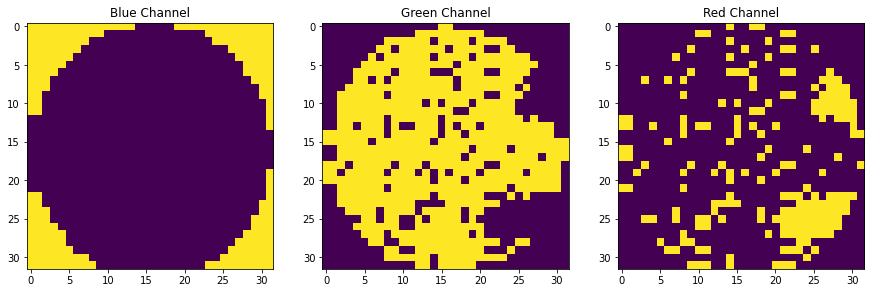

In [ ]:
#Splitting into channels
blue,green,red = cv2.split(x_train[19])
# Plotting the images
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
plt.title("Blue Channel")
plt.imshow(blue)
fig.add_subplot(132)
plt.title("Green Channel")
plt.imshow(green)
fig.add_subplot(133)
plt.title("Red Channel")
plt.imshow(red)
plt.show()

In [ ]:
pca_b = PCA(n_components=7)
pca_b.fit(blue)
trans_pca_b = pca_b.transform(blue)
pca_g = PCA(n_components=7)
pca_g.fit(green)
trans_pca_g = pca_g.transform(green)
pca_r = PCA(n_components=7)
pca_r.fit(red)
trans_pca_r = pca_r.transform(red)

In [ ]:
print(trans_pca_b.shape)
print(trans_pca_g.shape)
print(trans_pca_r.shape)

(32, 5)
(32, 5)
(32, 8)


In [ ]:
print(f"Blue Channel : {sum(pca_b.explained_variance_ratio_)}")
print(f"Green Channel: {sum(pca_g.explained_variance_ratio_)}")
print(f"Red Channel  : {sum(pca_r.explained_variance_ratio_)}")

Blue Channel : 0.966586306448865
Green Channel: 0.7215829248001393
Red Channel  : 0.5958015786842809


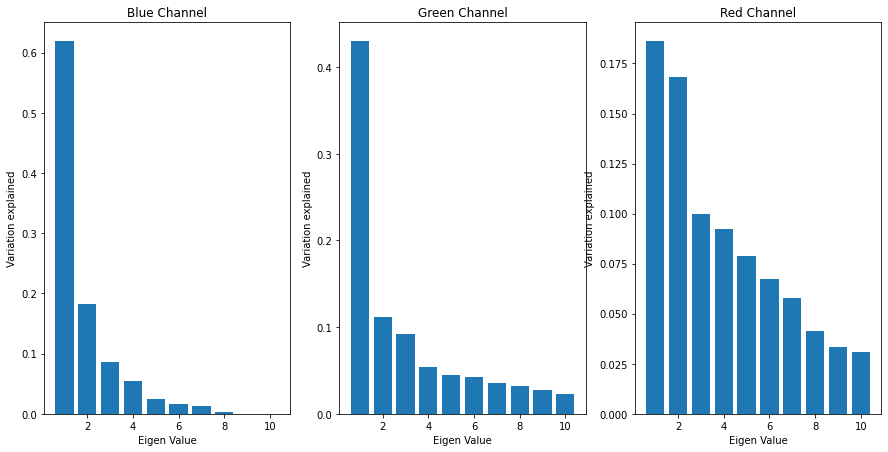

In [ ]:
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
plt.title("Blue Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,11)),pca_b.explained_variance_ratio_)
fig.add_subplot(132)
plt.title("Green Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,11)),pca_g.explained_variance_ratio_)
fig.add_subplot(133)
plt.title("Red Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,11)),pca_r.explained_variance_ratio_)
plt.show()

In [ ]:
# Reconstruct the image

In [ ]:
# data_original = np.dot(data_reduced, pca.components_) + pca.mean_
b_arr = pca_b.inverse_transform(trans_pca_b)
g_arr = pca_g.inverse_transform(trans_pca_g)
r_arr = pca_r.inverse_transform(trans_pca_r)
print(b_arr.shape, g_arr.shape, r_arr.shape)

(32, 32) (32, 32) (32, 32)


In [ ]:
img_reduced= (cv2.merge((b_arr, g_arr, r_arr)))
print(img_reduced.shape)

(32, 32, 3)


In [ ]:
def parse(ary):
  A = np.where(ary == max(ary), 1, 0)
  if np.random.binomial(1,p=0.03) == 1:
    A[1] = 0 if A[1]==1 else A[1]
    A[2] = 1 if A[0]==0 and A[1]==0 and A[2]==0 else A[2]
  return A

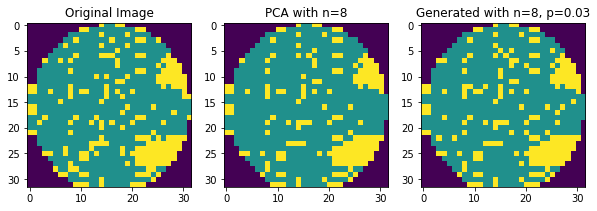

In [ ]:
fig = plt.figure(figsize = (10, 7.2))
fig.add_subplot(131)
plt.title("Original Image")
plt.imshow(np.argmax(x_train[19], axis=2))
fig.add_subplot(132)
plt.title("PCA with n=8")
plt.imshow(np.argmax(img_reduced, axis=2))
fig.add_subplot(133)
plt.title("Generated with n=8, p=0.03")
plt.imshow(np.argmax(np.array([np.array(list(map(parse, ary))) for ary in img_reduced]), axis=2))
plt.show()

In [ ]:
np.where(y_train=='Edge-Loc')

In [7]:
# Generate data
def parse(ary):
  A = np.where(ary == max(ary), 1, 0)
  if np.random.binomial(1,p=0.03) == 1:
    A[1] = 0 if A[1]==1 else A[1]
    A[2] = 1 if A[0]==0 and A[1]==0 and A[2]==0 else A[2]
  return A

def gen_pca(wafer):
  blue,green,red = cv2.split(wafer)
  b_arr_ = pca.fit_transform(blue)
  b_arr = pca.inverse_transform(b_arr_)
  g_arr_ = pca.fit_transform(green)
  g_arr = pca.inverse_transform(g_arr_)
  r_arr_ = pca.fit_transform(red)
  r_arr = pca.inverse_transform(r_arr_)
  gen = (cv2.merge((b_arr, g_arr, r_arr)))
  return gen

def gen_data(wafer, label, n=8):
    gen_x = np.zeros((1, 32, 32, 3))
    global pca
    pca = PCA(n_components=n)

    for i in tqdm(range((1000//len(wafer)) + 1)):
      pca_gen_x = np.zeros((len(wafer), 32, 32, 3))
      for j in range(len(wafer)):
        pca_gen_x[j] = np.array([np.array(list(map(parse, ary))) for ary in gen_pca(wafer[j])])
      gen_x = np.concatenate((gen_x, pca_gen_x), axis=0)
    gen_y = np.full((len(gen_x), 1), label)
    return gen_x[1:], gen_y[1:]

def rot_data(wafer, label):
    rot_x = np.zeros((1, 32, 32, 3))

    for i in tqdm(range(5000 - len(y_train[y_train==label]))):
        n = np.random.randint(len(wafer))
        roted_gen_x = ndimage.rotate(x_train[np.where(y_train==label)[0][n]], np.random.randint(360), axes=(0,1), mode='constant', order = 0, reshape=False).reshape(1,32,32,3)
        rot_x = np.concatenate((rot_x, roted_gen_x), axis=0)
    rot_y = np.full((len(rot_x), 1), label)
    return rot_x[1:], rot_y[1:]

In [8]:
x_train_org = x_train.copy()
y_train_org = y_train.copy()
for f in labels :  
    if f == 'none' : 
        continue    
    gen_x, gen_y = gen_data(x_train[np.where(y_train==f)[0]], f)
    x_train = np.concatenate((x_train, gen_x), axis=0)
    y_train = np.concatenate((y_train, gen_y))

for f in labels :  
    if f == 'none' : 
        continue    
    rot_x, rot_y = rot_data(x_train[np.where(y_train==f)[0]], f)
    x_train = np.concatenate((x_train, rot_x), axis=0)
    y_train = np.concatenate((y_train, rot_y))

100%|██████████| 3889/3889 [00:51<00:00, 74.98it/s]


In [9]:
print('After Generating new x shape : {}, new y shape : {}'.format(x_train.shape, y_train.shape))

After Generating new x shape : (40310, 32, 32, 3), new y shape : (40310, 1)


In [10]:
for f in labels :
    print('{} : {}'.format(f, len(y_train[y_train==f]))) 

Center : 5000
Edge-Loc : 5000
Edge-Ring : 5000
Loc : 5000
Near-full : 5000
Random : 5000
Scratch : 5000
none : 5310


In [11]:
def shuffle_two(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [12]:
x_train, y_train = shuffle_two(x_train, y_train)

In [ ]:
x_test, y_test = shuffle_two(x_test, y_test)

In [15]:
np.where(y_train=='Edge-Ring')

(array([    8,    11,    12, ..., 40266, 40292, 40303]),
 array([0, 0, 0, ..., 0, 0, 0]))

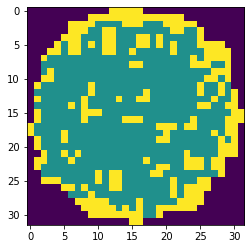

In [16]:
plt.imshow(np.argmax(x_train[8], axis=2))

# **Convolutional AE**

In [ ]:
with open('dataset.pickle', 'rb') as file:
    dataset = pickle.load(file)
x_test = dataset.get("x_test")
x_train = dataset.get("x_train")
y_train = dataset.get("y_train")
y_test = dataset.get("y_test")

In [ ]:
# former
def encoder(input_img):
    #encoder
    #input = 32 x 32 x 3 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(padding='same')(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(padding='same')(conv2) # 8 x 8 x 64
    return pool2

def decoder(conv4):
    #decoder
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4) # 8 x 8 x 64
    up1 = UpSampling2D()(conv5) # 16 x 16 x 64
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    conv6 = BatchNormalization()(conv6)
    up2 = UpSampling2D()(conv6)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2) # 32 x 32 x 1
    return decoded

In [ ]:
input_shape = Input(shape=(32, 32, 3))

In [ ]:
def CAE(input_shape=(32, 32, 3)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='conv1', input_shape=input_shape))
    model.add(MaxPooling2D(padding='same'))
    # model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2'))
    # model.add(BatchNormalization())
    # model.add(MaxPooling2D(padding='same'))
    # model.add(Flatten())
    # model.add(Dense(units=10, name='embedding'))
    # model.add(Dense(units=64*16*16, activation='relu'))
    # model.add(Reshape((16, 16, 64)))
    # model.add(Conv2DTranspose(64, (3,3), padding='same', activation='relu', name='deconv3'))
    # model.add(UpSampling2D())
    model.add(Conv2DTranspose(64, (3,3), padding='same', activation='relu', name='deconv2'))
    # model.add(BatchNormalization())
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(3, (3,3), padding='same', name='deconv1'))
    return model

In [ ]:
AEncoder = CAE()
AEncoder.summary()
AEncoder.compile(loss='mse', optimizer='adam')
AEncoder.fit(x_train, x_train, epochs=50, batch_size=500, verbose=2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
deconv2 (Conv2DTranspose)    (None, 16, 16, 64)        36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
deconv1 (Conv2DTranspose)    (None, 32, 32, 3)         1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
14/14 - 1s - loss: 0.1304
Epoch 2/50
14/14 - 0s - loss: 0.0753
Epoch 3/50
14/14 - 0s - loss: 0.0601
Epoch

In [ ]:
np.where(y_train=='Edge-Ring')

(array([  10,   71,  331,  387,  533,  842, 1069, 1397, 1468, 1579, 1610,
        1961, 1969, 1977, 2184, 2369, 2426, 2463, 2468, 2482, 2484, 2486,
        2758, 2901, 2911, 2954, 2989, 2993, 3147, 3204, 3242, 3320, 3325,
        3353, 3445, 3549, 3634, 3672, 3808, 3822, 3871, 3952, 3958, 4080,
        4417, 4483, 4487, 4557, 4788, 4860, 4968, 4976, 5028, 5118, 5277,
        5337, 5425, 5550, 5699, 5772, 5790, 5824, 5828, 5979, 6144, 6371,
        6405, 6510, 6523]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]))

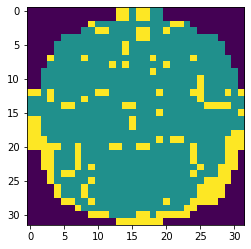

In [ ]:
plt.imshow(np.argmax(x_train[10], axis=2))

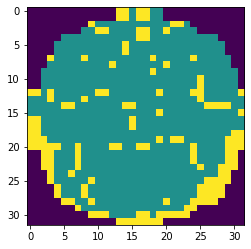

In [ ]:
gen_x = np.argmax(AEncoder.predict(x_train), axis=3)
plt.imshow(gen_x[10])

In [ ]:
# Generate data
def gen_data(wafer, label):
    gen_x = np.zeros((1, 32, 32, 3))
    
    for i in tqdm(range((1000//len(wafer)) + 1)):
        noised_encoded_x = wafer + np.random.normal(loc=0, scale=0.1, size = (len(wafer), 32, 32, 3))  
        noised_gen_x = AEncoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    gen_y = np.full((len(gen_x), 1), label)
    return gen_x[1:], gen_y[1:]

def rot_data(wafer, label):
    rot_x = np.zeros((1, 32, 32, 3))

    for i in tqdm(range(5000 - len(y_train[y_train==label]))):
        n = np.random.randint(len(wafer))
        roted_gen_x = ndimage.rotate(x_train[np.where(y_train==label)[0][n]], np.random.randint(360), axes=(0,1), mode='constant', order = 0, reshape=False).reshape(1,32,32,3)
        rot_x = np.concatenate((rot_x, roted_gen_x), axis=0)
    rot_y = np.full((len(rot_x), 1), label)
    return rot_x[1:], rot_y[1:]

In [ ]:
x_train_org = x_train.copy()
y_train_org = y_train.copy()
for f in labels :  
    if f == 'none' : 
        continue    
    gen_x, gen_y = gen_data(x_train[np.where(y_train==f)[0]], f)
    x_train = np.concatenate((x_train, gen_x), axis=0)
    y_train = np.concatenate((y_train, gen_y))

for f in labels :  
    if f == 'none' : 
        continue    
    rot_x, rot_y = rot_data(x_train[np.where(y_train==f)[0]], f)
    x_train = np.concatenate((x_train, rot_x), axis=0)
    y_train = np.concatenate((y_train, rot_y))

100%|██████████| 3889/3889 [00:59<00:00, 65.13it/s]


In [ ]:
print('After Generating new x shape : {}, new y shape : {}'.format(x_train.shape, y_train.shape))

After Generating new x shape : (40310, 32, 32, 3), new y shape : (40310, 1)


In [ ]:
for f in labels :
    print('{} : {}'.format(f, len(y_train[y_train==f]))) 

Center : 5000
Edge-Loc : 5000
Edge-Ring : 5000
Loc : 5000
Near-full : 5000
Random : 5000
Scratch : 5000
none : 5310


In [ ]:
def shuffle_two(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
x_train, y_train = shuffle_two(x_train, y_train)

In [ ]:
x_test, y_test = shuffle_two(x_test, y_test)

In [ ]:
np.where(y_train=='Edge-Ring')

(array([   16,    30,    31, ..., 40279, 40290, 40294]),
 array([0, 0, 0, ..., 0, 0, 0]))

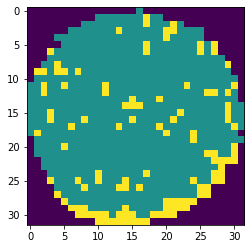

In [ ]:
plt.imshow(np.argmax(x_train[16], axis=2))

# **Denoising AE**

In [ ]:
with open('dataset.pickle', 'rb') as file:
    dataset = pickle.load(file)
x_test = dataset.get("x_test")
x_train = dataset.get("x_train")
y_train = dataset.get("y_train")
y_test = dataset.get("y_test")

In [ ]:
# denoising autoencoder
noise = np.random.normal(loc=0, scale=0.5, size=x_train.shape)
x_train_noise = x_train + noise

In [ ]:
def DAE(input_shape=(32, 32, 3)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='conv1', input_shape=input_shape))
    model.add(MaxPooling2D(padding='same'))
    # model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2'))
    # model.add(BatchNormalization())
    # model.add(MaxPooling2D(padding='same'))
    # model.add(Conv2DTranspose(64, (3, 3), padding='same', activation='relu', name='conv3'))
    # model.add(UpSampling2D())
    model.add(Conv2DTranspose(64, (3,3), padding='same', activation='relu', name='conv4'))
    # model.add(BatchNormalization())
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid', name='conv5'))
    return model

In [ ]:
DAEncoder = DAE()
DAEncoder.summary()
DAEncoder.compile(loss='mse', optimizer='adam')
DAEncoder.fit(x_train_noise, x_train, epochs=50, batch_size=500, verbose=2)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv4 (Conv2DTranspose)      (None, 16, 16, 64)        36928     
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv5 (Conv2DTranspose)      (None, 32, 32, 3)         1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
14/14 - 1s - loss: 0.1429
Epoch 2/50
14/14 - 0s - loss: 0.0909
Epoch 3/50
14/14 - 0s - loss: 0.0785
Epoch

In [ ]:
np.where(y_train=='Scratch')

(array([   9,   99,  109,  176,  225,  234,  239,  299,  444,  498,  527,
         593,  686,  802,  962,  967, 1024, 1031, 1097, 1182, 1267, 1514,
        1520, 1583, 1599, 1734, 1856, 1882, 1930, 1963, 1964, 2040, 2058,
        2200, 2249, 2252, 2260, 2288, 2403, 2406, 2485, 2494, 2628, 2634,
        2673, 2798, 2839, 2881, 2900, 3002, 3024, 3086, 3114, 3216, 3264,
        3278, 3339, 3365, 3494, 3619, 3719, 3720, 3925, 3984, 4033, 4076,
        4142, 4198, 4201, 4406, 4443, 4451, 4648, 4667, 4689, 4750, 4780,
        4799, 4872, 5021, 5088, 5218, 5286, 5318, 5462, 5483, 5509, 5680,
        5688, 5723, 5784, 5785, 5802, 5893, 6116, 6155, 6250, 6257, 6364,
        6517, 6527]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0,

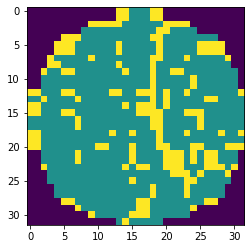

In [ ]:
plt.imshow(np.argmax(x_train[176], axis=2))

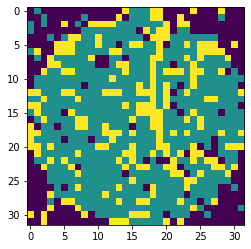

In [ ]:
plt.imshow(np.argmax(x_train_noise[176], axis=2)) 

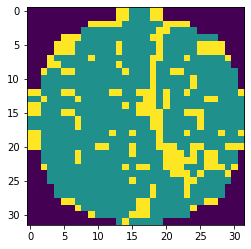

In [ ]:
x_noise = DAEncoder.predict(x_train) 
plt.imshow(np.argmax(x_noise[176], axis=2))

In [ ]:
# Generate data
def gen_data(wafer, label):
    gen_x = np.zeros((1, 32, 32, 3))
    
    for i in tqdm(range((1000//len(wafer)) + 1)):
        noised_encoded_x = wafer + np.random.normal(loc=0, scale=0.1, size = (len(wafer), 32, 32, 3))  
        noised_gen_x = DAEncoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    gen_y = np.full((len(gen_x), 1), label)
    return gen_x[1:], gen_y[1:]

def rot_data(wafer, label):
    rot_x = np.zeros((1, 32, 32, 3))

    for i in tqdm(range(5000 - len(y_train[y_train==label]))):
        n = np.random.randint(len(wafer))
        roted_gen_x = ndimage.rotate(x_train[np.where(y_train==label)[0][n]], np.random.randint(360), axes=(0,1), mode='constant', order = 0, reshape=False).reshape(1,32,32,3)
        rot_x = np.concatenate((rot_x, roted_gen_x), axis=0)
    rot_y = np.full((len(rot_x), 1), label)
    return rot_x[1:], rot_y[1:]

In [ ]:
x_train_org = x_train.copy()
y_train_org = y_train.copy()
for f in labels :  
    if f == 'none' : 
        continue    
    gen_x, gen_y = gen_data(x_train[np.where(y_train==f)[0]], f)
    x_train = np.concatenate((x_train, gen_x), axis=0)
    y_train = np.concatenate((y_train, gen_y))

for f in labels :  
    if f == 'none' : 
        continue    
    rot_x, rot_y = rot_data(x_train[np.where(y_train==f)[0]], f)
    x_train = np.concatenate((x_train, rot_x), axis=0)
    y_train = np.concatenate((y_train, rot_y))

100%|██████████| 3889/3889 [00:50<00:00, 76.39it/s]


In [ ]:
print('After Generate new x shape : {}, new y shape : {}'.format(x_train.shape, y_train.shape))

After Generate new x shape : (40310, 32, 32, 3), new y shape : (40310, 1)


In [ ]:
for f in labels :
    print('{} : {}'.format(f, len(y_train[y_train==f]))) 

Center : 5000
Edge-Loc : 5000
Edge-Ring : 5000
Loc : 5000
Near-full : 5000
Random : 5000
Scratch : 5000
none : 5310


In [ ]:
def shuffle_two(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
x_train, y_train = shuffle_two(x_train, y_train)

In [ ]:
x_test, y_test = shuffle_two(x_test, y_test)

# **Variational AE**

In [ ]:
with open('dataset.pickle', 'rb') as file:
    dataset = pickle.load(file)
x_test = dataset.get("x_test")
x_train = dataset.get("x_train")
y_train = dataset.get("y_train")
y_test = dataset.get("y_test")

In [ ]:
x_train.shape

(6531, 32, 32, 3)

In [ ]:
image_size = x_train.shape[1]
original_dim = image_size * image_size * 3
x_traint = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
image_shape = (32, 32, 3)
input_shape = (original_dim, )
latent_dim = 6
batch_size = 100
epochs = 50
epsilon_std = 1.0

In [ ]:
image_shape = (32, 32, 3)
original_dim = image_shape[0] * image_shape[1] * image_shape[2]
input_shape = (original_dim,)

def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

inputs = Input(shape=input_shape)
x = Reshape(image_shape)(inputs)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
label_inputs = Input(shape=(original_dim,), name='label')
x = Concatenate()([latent_inputs, label_inputs])
x = Dense(128, activation='relu')(x)
x = Dense(16 * 16 * 32, activation='relu')(x)
x = Reshape((16, 16, 32))(x)
x = Dropout(0.25)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
outputs = Reshape(input_shape)(x)

decoder = Model([latent_inputs, label_inputs], outputs, name='decoder')
decoder.summary()
# variational autoencoder
outputs = decoder([encoder(inputs)[2], label_inputs])
vae = Model([inputs, label_inputs], outputs, name='vae_mlp')
vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 3072)]       0                                            
__________________________________________________________________________________________________
reshape_55 (Reshape)            (None, 32, 32, 3)    0           input_22[0][0]                   
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 32, 32, 32)   896         reshape_55[0][0]                 
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 32, 32, 32)   9248        conv2d_72[0][0]                  
____________________________________________________________________________________________

In [ ]:
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.fit([x_traint, x_traint], epochs=50, batch_size=500, verbose=2)

Epoch 1/50
14/14 - 18s - loss: 319.5547
Epoch 2/50
14/14 - 0s - loss: 238.2240
Epoch 3/50
14/14 - 0s - loss: 233.2329
Epoch 4/50
14/14 - 0s - loss: 226.4067
Epoch 5/50
14/14 - 0s - loss: 219.6136
Epoch 6/50
14/14 - 0s - loss: 215.5431
Epoch 7/50
14/14 - 0s - loss: 212.8602
Epoch 8/50
14/14 - 0s - loss: 210.5009
Epoch 9/50
14/14 - 0s - loss: 206.2811
Epoch 10/50
14/14 - 0s - loss: 205.9559
Epoch 11/50
14/14 - 0s - loss: 204.4247
Epoch 12/50
14/14 - 0s - loss: 203.4497
Epoch 13/50
14/14 - 0s - loss: 203.0887
Epoch 14/50
14/14 - 0s - loss: 199.5006
Epoch 15/50
14/14 - 0s - loss: 198.8440
Epoch 16/50
14/14 - 0s - loss: 199.2984
Epoch 17/50
14/14 - 0s - loss: 199.1217
Epoch 18/50
14/14 - 0s - loss: 197.3657
Epoch 19/50
14/14 - 0s - loss: 196.1072
Epoch 20/50
14/14 - 0s - loss: 196.6015
Epoch 21/50
14/14 - 0s - loss: 195.1292
Epoch 22/50
14/14 - 0s - loss: 193.6192
Epoch 23/50
14/14 - 0s - loss: 194.3055
Epoch 24/50
14/14 - 0s - loss: 194.0440
Epoch 25/50
14/14 - 0s - loss: 192.4981
Epoch 26

In [ ]:
img = np.reshape(x_traint[0], (32, 32, 3))

In [ ]:
img = vae.predict([x_traint, x_traint])[0]
img = np.reshape(img, (32, 32, 3))

In [ ]:
x_train[0].shape

(32, 32, 3)

In [ ]:
img.shape

(32, 32, 3)

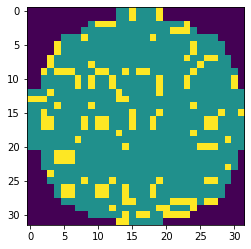

In [ ]:
plt.imshow(np.argmax(x_train[0], axis=2))

In [ ]:
np.where(y_train=='Edge-Ring')

(array([  10,   71,  331,  387,  533,  842, 1069, 1397, 1468, 1579, 1610,
        1961, 1969, 1977, 2184, 2369, 2426, 2463, 2468, 2482, 2484, 2486,
        2758, 2901, 2911, 2954, 2989, 2993, 3147, 3204, 3242, 3320, 3325,
        3353, 3445, 3549, 3634, 3672, 3808, 3822, 3871, 3952, 3958, 4080,
        4417, 4483, 4487, 4557, 4788, 4860, 4968, 4976, 5028, 5118, 5277,
        5337, 5425, 5550, 5699, 5772, 5790, 5824, 5828, 5979, 6144, 6371,
        6405, 6510, 6523]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]))

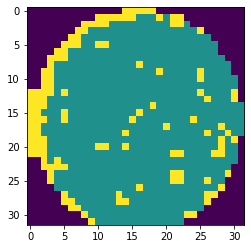

In [ ]:
plt.imshow(np.argmax(x_train[1610], axis=2))

In [ ]:
gen_x = vae.predict([x_traint, x_traint])

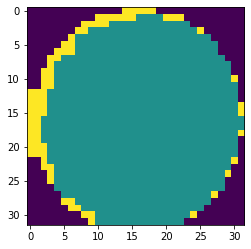

In [ ]:
img = np.reshape(gen_x, (len(x_train), 32, 32, 3))
plt.imshow(np.argmax(img[1610], axis=2))

In [ ]:
# Generate data
def gen_data(wafer, label):
    gen_x = np.zeros((1, 32, 32, 3))
    
    for i in tqdm(range((1000//len(wafer)) + 1)):
        wafer = wafer.reshape((len(wafer), np.prod(wafer.shape[1:])))
        noised_encoded_x = wafer + np.random.normal(loc=0, scale=0.1, size = (len(wafer), 32*32*3))  
        noised_gen_x = vae.predict([noised_encoded_x, noised_encoded_x])
        noised_gen_x = np.reshape(noised_gen_x, (len(wafer), 32, 32, 3))
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    gen_y = np.full((len(gen_x), 1), label)
    return gen_x[1:], gen_y[1:]

def rot_data(wafer, label):
    rot_x = np.zeros((1, 32, 32, 3))

    for i in tqdm(range(5000 - len(y_train[y_train==label]))):
        n = np.random.randint(len(wafer))
        roted_gen_x = ndimage.rotate(x_train[np.where(y_train==label)[0][n]], np.random.randint(360), axes=(0,1), mode='constant', order = 0, reshape=False).reshape(1,32,32,3)
        rot_x = np.concatenate((rot_x, roted_gen_x), axis=0)
    rot_y = np.full((len(rot_x), 1), label)
    return rot_x[1:], rot_y[1:]

In [ ]:
x_train_org = x_train.copy()
y_train_org = y_train.copy()
for f in labels :  
    if f == 'none' : 
        continue    
    gen_x, gen_y = gen_data(x_train[np.where(y_train==f)[0]], f)
    x_train = np.concatenate((x_train, gen_x), axis=0)
    y_train = np.concatenate((y_train, gen_y))

for f in labels :  
    if f == 'none' : 
        continue    
    rot_x, rot_y = rot_data(x_train[np.where(y_train==f)[0]], f)
    x_train = np.concatenate((x_train, rot_x), axis=0)
    y_train = np.concatenate((y_train, rot_y))

100%|██████████| 3889/3889 [00:47<00:00, 81.56it/s]


In [ ]:
print('After Generating new x shape : {}, new y shape : {}'.format(x_train.shape, y_train.shape))

After Generating new x shape : (40310, 32, 32, 3), new y shape : (40310, 1)


In [ ]:
for f in labels :
    print('{} : {}'.format(f, len(y_train[y_train==f]))) 

Center : 5000
Edge-Loc : 5000
Edge-Ring : 5000
Loc : 5000
Near-full : 5000
Random : 5000
Scratch : 5000
none : 5310


In [ ]:
def shuffle_two(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
x_train, y_train = shuffle_two(x_train, y_train)

In [ ]:
x_test, y_test = shuffle_two(x_test, y_test)

In [ ]:
np.where(y_train=='Edge-Ring')

(array([   32,    39,    46, ..., 40276, 40282, 40298]),
 array([0, 0, 0, ..., 0, 0, 0]))

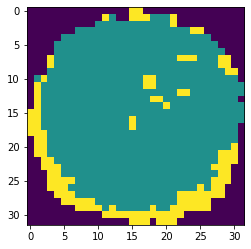

In [ ]:
plt.imshow(np.argmax(x_train[32], axis=2))

# **Bernoulli Bootstrap with p=0.05**

Failure type : ['Edge-Loc'] 


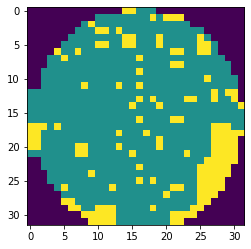

In [ ]:
plt.imshow(x[0])
print('Failure type : {} '.format(y[0]))

Failure type : ['Edge-Loc'] 


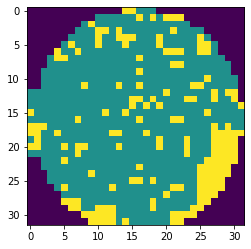

In [ ]:
plt.imshow(np.argmax(x_new[0],axis=2))
print('Failure type : {} '.format(y[0]))

In [ ]:
def aply(ary):
  lst = [z+np.random.binomial(1,p=0.05) if z != 0 else z for z in ary]
  lst = [1 if z == 3 else z for z in lst]
  return lst

In [ ]:
# Generate data
def gen_data(wafer, label):
    gen_x = []
    for i in tqdm(range((7000//len(wafer)) + 1)):
      for lst in wafer:
        gen_x.append(np.array(list(map(aply, lst))))
    # gen_x = np.concatenate((wafer, temp))   
    gen_y = np.full((len(gen_x), 1), label)
    
    return gen_x, gen_y

In [ ]:
x_train_org = x_train.copy()
y_train_org = y_train.copy()

In [ ]:
for f in labels :  
    if f == 'none' : 
        continue    
    g_x, g_y = gen_data(x_train[np.where(y_train==f)[0]], f)
    x_train = np.concatenate((x_train, g_x))
    y_train = np.concatenate((y_train, g_y))

100%|██████████| 130/130 [00:26<00:00,  4.83it/s]


In [ ]:
print('After Generate new x shape : {}, new y shape : {}'.format(x_train.shape, y_train.shape))

After Generate new x shape : (50112, 32, 32), new y shape : (50112, 1)


In [ ]:
for f in labels :
    print('{} : {}'.format(f, len(y_train[y_train==f]))) 

Center : 7067
Edge-Loc : 7176
Edge-Ring : 7052
Loc : 7208
Near-full : 7030
Scratch : 7074
none : 7505


In [ ]:
def shuffle_two(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
x_train, y_train = shuffle_two(x_train, y_train)

Failure type : ['Scratch'] 


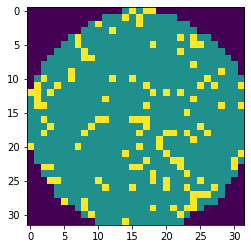

In [ ]:
plt.imshow(x_train[442])
print('Failure type : {} '.format(y_train[442]))

In [ ]:
# For CNN models
new_x_train = np.zeros((len(x_train), 32, 32, 3))
for w in tqdm(range(len(x_train))):
    for i in range(32):
        for j in range(32):
            new_x_train[w, i, j, int(x_train[w, i, j])] = 1

new_x_test = np.zeros((len(x_test), 32, 32, 3))
for w in tqdm(range(len(x_test))):
    for i in range(32):
        for j in range(32):
            new_x_test[w, i, j, int(x_test[w, i, j])] = 1

new_x_train.shape, new_x_test.shape

100%|██████████| 5279/5279 [00:04<00:00, 1254.72it/s]


((50112, 32, 32, 3), (5279, 32, 32, 3))

# **Load dataset from pickle**

In [14]:
# # saving augmented x and y
# dataset_pca_noise = {"y_train": y_train, "y_test": y_test, "x_train": x_train, "x_test": x_test}
# with open('dataset_pca_noise.pickle', 'wb') as file:
#     pickle.dump(dataset_pca_noise, file)

In [ ]:
with open('dataset_dae.pickle', 'rb') as file:
    dataset_ae = pickle.load(file)

In [ ]:
x_test = dataset_ae.get("x_test")
x_train = dataset_ae.get("x_train")
y_train = dataset_ae.get("y_train")
y_test = dataset_ae.get("y_test")

# **Apply CNN**

In [17]:
for i, l in enumerate(labels):
    y_train[y_train==l] = i
y_train_ohe = to_categorical(y_train)
print(y_train_ohe[291])

[0. 0. 0. 0. 1. 0. 0. 0.]


In [18]:
for i, l in enumerate(labels):
    y_test[y_test==l] = i
y_test_ohe = to_categorical(y_test)
print(y_test_ohe[291])

[0. 0. 0. 0. 0. 0. 0. 1.]


In [19]:
# y_OH = OneHotEncoder()
# y_train_ohe = y_OH.fit_transform(y_train)
# print(y_OH.get_feature_names())
# y_train_ohe = y_train_ohe.toarray()
# print(y_train_ohe[291])

In [20]:
# y_OH2 = OneHotEncoder()
# y_test_ohe = y_OH2.fit_transform(y_test)
# print(y_OH2.get_feature_names())
# y_test_ohe = y_test_ohe.toarray()
# print(y_test_ohe[133])

In [21]:
print(x_train.shape, y_train_ohe.shape)

(40310, 32, 32, 3) (40310, 8)


In [22]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch < 10:
        lr = lr
    elif epoch < 20 :
        lr = lr * 0.1
    else:
        lr = lr * 0.01
    print('Learning rate: ', lr)
    return lr

In [23]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

In [24]:
def plot_confusion_matrix2(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# **Simple CNN**

In [28]:
data_name = 'PCA'
number = '3'
batch_sizes = 100
weight_decay = 1e-4
epochs = 50
model = "Simple CNN"
dir = os.path.join(os.getcwd(),data_name)
os.makedirs(os.path.join(dir,'model_output',number,model), exist_ok=True)
os.makedirs(os.path.join(dir,'train_valid_output',number), exist_ok=True)

In [29]:
input = Input(shape = (32,32,3))

conv_1 = Conv2D(32, (3,3), padding = 'same')(input)
act_1 = Activation('relu')(conv_1)
conv_2 = Conv2D(32, (3,3))(act_1)
act_2 = Activation('relu')(conv_2)
pool_1 = MaxPooling2D(pool_size = (2,2))(act_2)
dropout_1 = Dropout(0.25)(pool_1)

conv_3 = Conv2D(64, (3,3), padding = 'same')(dropout_1)
act_3 = Activation('relu')(conv_3)
conv_4 = Conv2D(64, (3,3))(act_3)
act_4 = Activation('relu')(conv_4)
pool_2 = MaxPooling2D(pool_size = (2,2))(act_4)
dropout_2 = Dropout(0.25)(pool_2)

flat_1 = Flatten()(dropout_2)
dense_1 = Dense(512)(flat_1)
act_5 = Activation('relu')(dense_1)
dropout_3 = Dropout(0.5)(act_5)
output = Dense(8, activation = 'softmax')(dropout_3)

model0 = Model(inputs = input, outputs = output)


In [30]:
model0.summary()
# plot_model(model6, show_shapes=True)
filepath =  os.path.join(dir,'model_output',number, model,'{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
                  LearningRateScheduler(lr_schedule,verbose=1)] 
model0.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['AUC', 'Precision','Recall'])
auto = model0.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), epochs=50, batch_size=100, callbacks=callbacks_list, shuffle=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 32)        0   

In [31]:
y_predict = model0.predict(x_test)
y_pred_ = np.ones(len(y_predict))
y_test_ = np.ones(len(y_test))
for i in range(len(y_pred_)):
    y_pred_[i] = np.argmax(y_predict[i])
    y_test_[i] = np.argmax(y_test_ohe[i])
print(classification_report(y_test_, y_pred_, target_names=labels))

              precision    recall  f1-score   support

      Center       0.76      0.81      0.79        27
    Edge-Loc       0.88      0.83      0.85       104
   Edge-Ring       0.84      0.94      0.89        17
         Loc       0.78      0.76      0.77       102
   Near-full       1.00      1.00      1.00        11
      Random       0.78      0.95      0.86        19
     Scratch       0.69      0.72      0.71        25
        none       0.98      0.98      0.98      1328

    accuracy                           0.95      1633
   macro avg       0.84      0.87      0.86      1633
weighted avg       0.95      0.95      0.95      1633



Confusion matrix, without normalization
Normalized confusion matrix


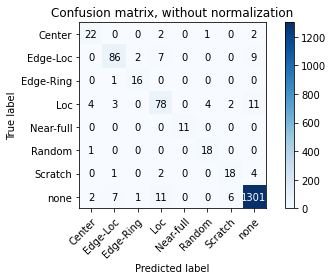

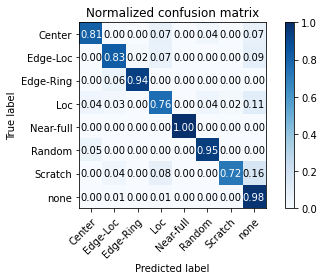

In [32]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix]
plot_confusion_matrix2(y_test_, y_pred_, classes=labels, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix]
plot_confusion_matrix2(y_test_, y_pred_, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()

# **AlexNet**

In [89]:
data_name = 'PCA'
number = '3'
batch_sizes = 32
weight_decay = 1e-4
epochs = 50
model = "AlexNet"
dir = os.path.join(os.getcwd(),data_name)
os.makedirs(os.path.join(dir,'model_output',number,model), exist_ok=True)
os.makedirs(os.path.join(dir,'train_valid_output',number), exist_ok=True)

In [53]:
# 참고 : https://github.com/eweill/keras-deepcv/blob/master/models/classification/alexnet.py

def Alexnet(img_shape=(224, 224, 3), n_classes=10, l2_reg=0., weights=None):

	# Initialize model
	alexnet = Sequential()

	# Layer 1
	alexnet.add(Conv2D(96, (11, 11), input_shape=img_shape,
		padding='same', kernel_regularizer=l2(l2_reg)))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 2
	alexnet.add(Conv2D(256, (5, 5), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 3
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(512, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 4
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))

	# Layer 5
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 6
	alexnet.add(Flatten())
	alexnet.add(Dense(3072))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 7
	alexnet.add(Dense(4096))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 8
	alexnet.add(Dense(n_classes))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('softmax'))

	if weights is not None:
		alexnet.load_weights(weights)

	return alexnet

In [90]:
model1 = Alexnet(img_shape=(32, 32, 3), n_classes=8)
model1.summary()
# plot_model(model1, show_shapes=True)

filepath =  os.path.join(dir,'model_output',number,model,'{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_loss', patience=10, mode="min"),
                  LearningRateScheduler(lr_schedule,verbose=1)]
model1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=[['AUC', 'Precision','Recall']])
auto = model1.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), epochs=30, batch_size=32, callbacks=callbacks_list, shuffle=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 32, 32, 96)        34944     
_________________________________________________________________
batch_normalization_54 (Batc (None, 32, 32, 96)        384       
_________________________________________________________________
activation_107 (Activation)  (None, 32, 32, 96)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 16, 16, 256)       614656    
_________________________________________________________________
batch_normalization_55 (Batc (None, 16, 16, 256)       1024      
_________________________________________________________________
activation_108 (Activation)  (None, 16, 16, 256)      

In [74]:
# filename =  os.path.join(dir,'model_output/3/AlexNet/018.h5')
# alex = load_model(filename)

In [91]:
y_predict = model1.predict(x_test)
y_pred_1 = np.ones(len(y_predict))
y_test_ = np.ones(len(y_test))
for i in range(len(y_pred_)):
    y_pred_1[i] = np.argmax(y_predict[i])
    y_test_[i] = np.argmax(y_test_ohe[i])
print(classification_report(y_test_, y_pred_1, target_names=labels))

              precision    recall  f1-score   support

      Center       0.77      0.85      0.81        27
    Edge-Loc       0.91      0.81      0.86       104
   Edge-Ring       0.89      0.94      0.91        17
         Loc       0.84      0.74      0.79       102
   Near-full       1.00      0.82      0.90        11
      Random       0.74      0.89      0.81        19
     Scratch       0.62      0.64      0.63        25
        none       0.97      0.99      0.98      1328

    accuracy                           0.95      1633
   macro avg       0.84      0.83      0.84      1633
weighted avg       0.95      0.95      0.95      1633



Confusion matrix, without normalization
Normalized confusion matrix


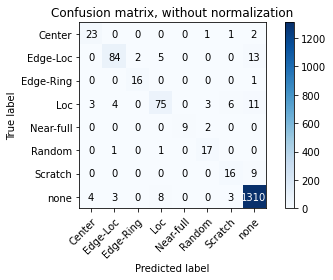

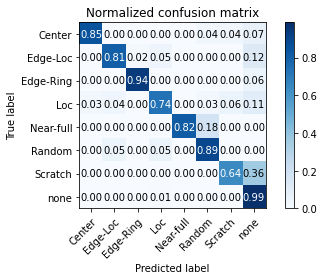

In [92]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix2(y_test_, y_pred_1, classes=labels, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix2(y_test_, y_pred_1, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()

# **VGGNet**

In [36]:
data_name = 'PCA'
number = '3'
batch_sizes = 50
weight_decay = 1e-4
epochs = 500
model = "VGG_simple"
dir = os.path.join(os.getcwd(),data_name)
os.makedirs(os.path.join(dir,'model_output',number,model), exist_ok=True)
os.makedirs(os.path.join(dir,'train_valid_output',number), exist_ok=True)

In [37]:
lamb = 0.001
drt = 0.4
def mcreate_model():
    input_shape = (32, 32, 3)
    input_tensor = Input(input_shape)
    
    #initializer: glorot_normal, glorot_uniform, he_normal, he_uniform

    conv_1 = Conv2D(32, (3,3), kernel_initializer='glorot_uniform', kernel_regularizer=l2(lamb), activation='relu',padding='same')(input_tensor)
    conv_2 = Conv2D(64, (3,3), kernel_initializer='glorot_uniform', kernel_regularizer=l2(lamb), activation='relu',padding='same')(conv_1)
    pool_1 = MaxPool2D((2,2), name = 'max_pool1')(conv_2)

    conv_3 = Conv2D(128, (3,3), kernel_initializer='glorot_uniform',activation='relu', kernel_regularizer=l2(lamb), padding='same')(pool_1)
    conv_4 = Conv2D(256, (3,3), kernel_initializer='glorot_uniform',activation='relu', kernel_regularizer=l2(lamb), padding='same')(conv_3)
    pool_2 = MaxPool2D((2,2), name = 'max_pool2')(conv_4)

    flat = Flatten()(pool_2)

    dense_1 = Dense(512, activation='relu')(flat)
    drop_1 = Dropout(drt)(dense_1)
    dense_2 = Dense(256, activation='relu')(drop_1)
    output_tensor = Dense(8, activation='softmax')(dense_2)

    model = Model(input_tensor, output_tensor)
 
    return model

In [38]:
model2 = mcreate_model()
model2.summary()
filepath =  os.path.join(dir,'model_output',number,'VGG_simple','{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_loss', patience=5, mode='min'),
                  LearningRateScheduler(lr_schedule,verbose=1)] 
model2.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['AUC', 'Precision','Recall'])
auto = model2.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), epochs=50, batch_size=300, callbacks=callbacks_list, shuffle=True)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 8, 8, 256)         0   

In [77]:
# filename =  os.path.join(dir,'model_output/3/VGG_simple/005.h5')
# vgg = load_model(filename)

In [39]:
y_predict = model2.predict(x_test)
y_pred_2 = np.ones(len(y_predict))
y_test_ = np.ones(len(y_test))
for i in range(len(y_pred_2)):
    y_pred_2[i] = np.argmax(y_predict[i])
    y_test_[i] = np.argmax(y_test_ohe[i])
print(classification_report(y_test_, y_pred_2, target_names=labels))

              precision    recall  f1-score   support

      Center       0.73      0.89      0.80        27
    Edge-Loc       0.77      0.85      0.81       104
   Edge-Ring       0.89      0.94      0.91        17
         Loc       0.76      0.75      0.75       102
   Near-full       1.00      1.00      1.00        11
      Random       0.86      0.95      0.90        19
     Scratch       0.59      0.52      0.55        25
        none       0.98      0.97      0.97      1328

    accuracy                           0.94      1633
   macro avg       0.82      0.86      0.84      1633
weighted avg       0.94      0.94      0.94      1633



Confusion matrix, without normalization
Normalized confusion matrix


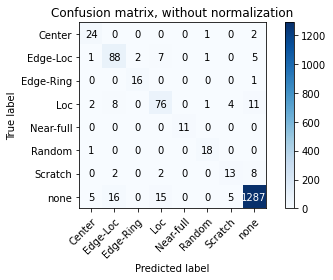

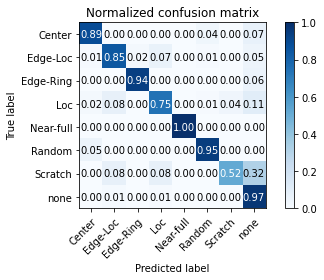

In [40]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix2(y_test_, y_pred_2, classes=labels, title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix2(y_test_, y_pred_2, classes=labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [41]:
def GAP_create_model():
    input_shape = (32, 32, 3)
    input_tensor = Input(input_shape)
    
    #initializer: glorot_normal, glorot_uniform, he_normal, he_uniform

    conv_1 = Conv2D(32, (3,3), kernel_initializer='he_normal', activation='relu',padding='same')(input_tensor)
    conv_2 = Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu',padding='same')(conv_1)

    pool_1 = MaxPool2D((2,2), name = 'max_pool1')(conv_2)

    conv_3 = Conv2D(128, (3,3), kernel_initializer='he_normal',activation='relu', padding='same')(pool_1)
    conv_4 = Conv2D(256, (3,3), kernel_initializer='he_normal',activation='relu', padding='same')(conv_3)

    pool_2 = GlobalAveragePooling2D()(conv_4) #GAP layer

    dense_1 = Dense(512, activation='relu')(pool_2)
    drop_1 = Dropout(0.4)(dense_1)
    dense_2 = Dense(256, activation='relu')(drop_1)
    output_tensor = Dense(8, activation='softmax')(dense_2)

    model = Model(input_tensor, output_tensor)
 
    return model

In [42]:
G_model = GAP_create_model()
filepath =  os.path.join(dir,'model_output',number,'GAP','{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_loss', patience=5, mode='min'),
                  LearningRateScheduler(lr_schedule,verbose=1)] 
G_model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['AUC', 'Precision','Recall'])
G_model.summary()
auto = G_model.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), epochs=50, batch_size=300, callbacks=callbacks_list, shuffle=True)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0   

In [43]:
y_predict = G_model.predict(x_test)
y_pred_3 = np.ones(len(y_predict))
for i in range(len(y_pred_3)):
    y_pred_3[i] = np.argmax(y_predict[i])
print(classification_report(y_test_, y_pred_3, target_names=labels))

              precision    recall  f1-score   support

      Center       0.56      0.81      0.67        27
    Edge-Loc       0.86      0.86      0.86       104
   Edge-Ring       0.89      0.94      0.91        17
         Loc       0.79      0.75      0.77       102
   Near-full       1.00      0.91      0.95        11
      Random       0.77      0.89      0.83        19
     Scratch       0.59      0.96      0.73        25
        none       0.99      0.97      0.98      1328

    accuracy                           0.94      1633
   macro avg       0.81      0.89      0.84      1633
weighted avg       0.95      0.94      0.95      1633



Confusion matrix, without normalization
Normalized confusion matrix


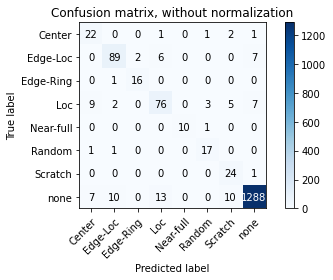

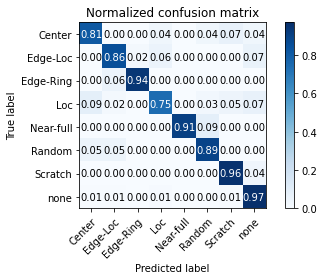

In [44]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix2(y_test_, y_pred_3, classes=labels, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix2(y_test_, y_pred_3, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()

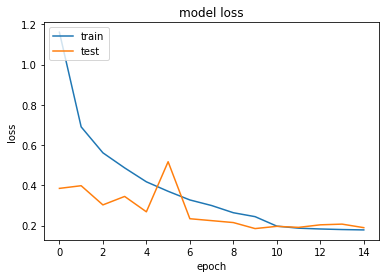

In [45]:
# loss plot
plt.plot(auto.history['loss'])
plt.plot(auto.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
def VGG16(classes=8):

    input_shape = (32, 32, 3)
    input_tensor = Input(input_shape)
    
    # Block 1
    x = Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(input_tensor)
    x = Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
    x = Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    x = Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
    x = Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), name='block4_pool')(x)

    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(1028, activation='relu', name='fc1')(x)
    x = Dense(1028, activation='relu', name='fc2')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    # Create model.
    model = Model(input_tensor, x, name='mvgg16') 

    return model

In [47]:
model3 = VGG16(classes=8)
model3.summary()
plot_model(model3, show_shapes=True)

filepath =  os.path.join(dir,'model_output',number,'VGG16','{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_recall', patience=5, mode='max'),
                  LearningRateScheduler(lr_schedule,verbose=1)] 
model3.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['AUC', 'Precision','Recall'])
auto = model3.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), epochs=50, batch_size=500, callbacks=callbacks_list, shuffle=True)

Model: "mvgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0    

In [48]:
loss=auto.history['loss']
val_loss=auto.history['val_loss']
auc=auto.history['auc']
val_auc=auto.history['val_auc']
precision=auto.history['precision']
val_precision=auto.history['val_precision']
recall=auto.history['recall']
val_recall=auto.history['val_recall']
epochs=range(1,len(loss)+1)

data = np.array([epochs,loss,val_loss,auc,val_auc,precision,val_precision,recall, val_recall]).T

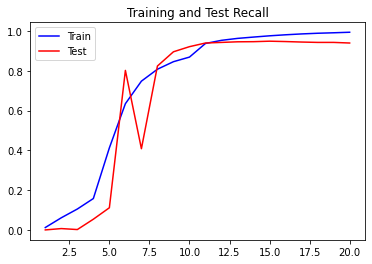

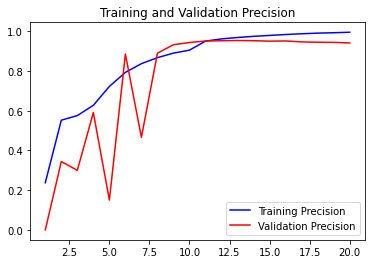

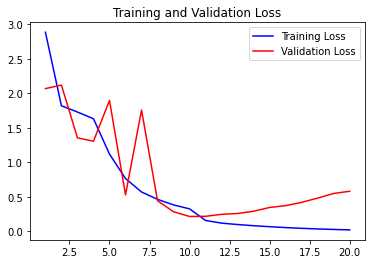

In [49]:
plt.plot(epochs,recall,'b',label='Train')
plt.plot(epochs,val_recall,'r',label='Test')
plt.title('Training and Test Recall')
plt.legend()
plt.figure()

plt.plot(epochs,precision,'b',label='Training Precision')
plt.plot(epochs,val_precision,'r',label='Validation Precision')
plt.title('Training and Validation Precision')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [50]:
y_predict = model3.predict(x_test)
y_pred_4 = np.ones(len(y_predict))
for i in range(len(y_pred_4)):
    y_pred_4[i] = np.argmax(y_predict[i])
print(classification_report(y_test_, y_pred_4, target_names=labels))

              precision    recall  f1-score   support

      Center       0.72      0.78      0.75        27
    Edge-Loc       0.81      0.82      0.81       104
   Edge-Ring       0.80      0.94      0.86        17
         Loc       0.70      0.76      0.73       102
   Near-full       1.00      0.91      0.95        11
      Random       0.81      0.89      0.85        19
     Scratch       0.81      0.68      0.74        25
        none       0.98      0.97      0.98      1328

    accuracy                           0.94      1633
   macro avg       0.83      0.84      0.83      1633
weighted avg       0.94      0.94      0.94      1633



Confusion matrix, without normalization
Normalized confusion matrix


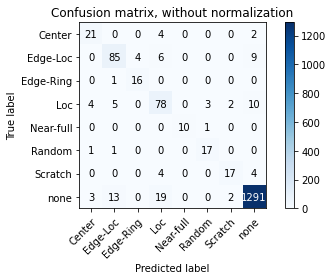

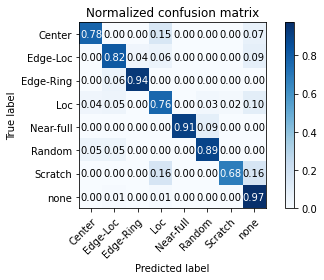

In [51]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix2(y_test_, y_pred_4, classes=labels, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix2(y_test_, y_pred_4, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()

# **ResNet**

In [59]:
data_name = 'PCA'
number = '3'
batch_sizes = 32
weight_decay = 1e-4
epochs = 50
model = "ResNet"
dir = os.path.join(os.getcwd(),data_name)
os.makedirs(os.path.join(dir,'model_output',number,model), exist_ok=True)
os.makedirs(os.path.join(dir,'train_valid_output',number), exist_ok=True)

In [60]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [61]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [62]:
def ResNet50(input_shape = (27, 27, 3), classes = 9):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((1, 1))(X_input)
    
    # Stage 1
    X = Conv2D(64, (3, 3), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32,32,128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32,32,128], stage=2, block='b')
    X = identity_block(X, 3, [32,32,128], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [64,64,256], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64,64,256], stage=3, block='b')
    X = identity_block(X, 3, [64,64,256], stage=3, block='c')
    X = identity_block(X, 3, [64,64,256], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=4, block='b')
    X = identity_block(X, 3, [128,128,512], stage=4, block='c')
    X = identity_block(X, 3, [128,128,512], stage=4, block='d')
    X = identity_block(X, 3, [128,128,512], stage=4, block='e')
    X = identity_block(X, 3, [128,128,512], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2,2), name = "avg_pool")(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [63]:
# ResNet18

In [64]:
def _resnet_block(input_tensor, filters, k=1, strides=(1, 1), weight_decay = weight_decay):

    init = input_tensor
    channel_axis = -1

    if strides != (1, 1) or init.get_shape()[channel_axis] != filters * k:
        x = Conv2D(filters * k, (1, 1), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay),
                      use_bias=False, strides=strides)(input_tensor)
        init = BatchNormalization(axis=channel_axis)(x)


    x = Conv2D(filters * k, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay),
               use_bias=False, strides=strides)(input_tensor)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters * k, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay),
               use_bias=False)(x)
    x = BatchNormalization(axis=channel_axis)(x)

    m = add([x, init])
    m = Activation('relu')(m)

    return m
def _resnet_bottleneck_block(input_tensor, filters, k=1, strides=(1, 1), weight_decay = weight_decay):

    init = input_tensor
    channel_axis = -1
    bottleneck_expand = 4

    if strides != (1, 1) or init.get_shape()[channel_axis] != bottleneck_expand * filters * k:
        x = Conv2D(bottleneck_expand * filters * k, (1, 1), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay),
                      use_bias=False, strides=strides)(input_tensor)
        init = BatchNormalization(axis=channel_axis)(x)


    x = Conv2D(filters * k, (1, 1), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay),
               use_bias=False)(input_tensor)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters * k, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay),
               use_bias=False, strides=strides)(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(bottleneck_expand * filters * k, (1, 1), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay),
               use_bias=False)(x)
    x = BatchNormalization(axis=channel_axis)(x)    

    m = add([x, init])
    m = Activation('relu')(m)

    return m

def _create_resnet(classes, img_input, initial_conv_filters, filters, depth, width, bottleneck, weight_decay):

    channel_axis = -1
    N = list(depth)

    # block 1 (initial conv block)
    x = Conv2D(initial_conv_filters, (7, 7), padding='same', use_bias=False, strides=(2, 2), kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(img_input)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # block 2 (projection block)
    for i in range(N[0]):
        if bottleneck:
            x = _resnet_bottleneck_block(x, filters[0], width)
        else:
            x = _resnet_block(x, filters[0], width)

    # block 3 - N
    for k in range(1, len(N)):
        if bottleneck:
            x = _resnet_bottleneck_block(x, filters[k], width, strides=(2, 2))
        else:
            x = _resnet_block(x, filters[k], width, strides=(2, 2))

        for i in range(N[k] - 1):
            if bottleneck:
                x = _resnet_bottleneck_block(x, filters[k], width)
            else:
                x = _resnet_block(x, filters[k], width)

    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, use_bias=False, kernel_regularizer=l2(weight_decay), activation='softmax')(x)


    return x

def ResNet(input_shape=None, initial_conv_filters=64, depth=[3, 4, 6, 3], filters=[64, 128, 256, 512],
             width=1, bottleneck=False, weight_decay=weight_decay, name=None, classes=1000):


    img_input = Input(shape=input_shape)

    x = _create_resnet(classes, img_input, initial_conv_filters, filters, depth, width, bottleneck, weight_decay)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.

    inputs = img_input

    # Create model.
    model = Model(inputs, x, name = name)

    return model

In [71]:
model6 = ResNet(input_shape=(32,32,3), depth=[2, 2, 2, 2], width=1, bottleneck=False, weight_decay=weight_decay, classes=8, name='ResNet18')
model6.summary()
filepath =  os.path.join(dir,'model_output',number, 'ResNet18','{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_loss', verbose=1, patience=10, mode='min'),
                  LearningRateScheduler(lr_schedule,verbose=1)] 
model6.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['AUC', 'Precision','Recall'])
auto = model6.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), epochs=50, batch_size=100, callbacks=callbacks_list, shuffle=True)

Model: "ResNet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 16, 16, 64)   9408        input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 8, 8, 64)     0           conv2d_45[0][0]                  
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 8, 8, 64)     36864       max_pooling2d_10[0][0]           
___________________________________________________________________________________________

In [84]:
# filename =  os.path.join(dir,'model_output/3/ResNet18/011.h5')
# resnet = load_model(filename)

In [85]:
y_predict = model6.predict(x_test)
y_pred_6 = np.ones(len(y_predict))
for i in range(len(y_pred_6)):
    y_pred_6[i] = np.argmax(y_predict[i])
print(classification_report(y_test_, y_pred_6, target_names=labels))

              precision    recall  f1-score   support

      Center       0.86      0.67      0.75        27
    Edge-Loc       0.85      0.79      0.82       104
   Edge-Ring       0.89      0.94      0.91        17
         Loc       0.84      0.74      0.79       102
   Near-full       0.92      1.00      0.96        11
      Random       0.80      0.84      0.82        19
     Scratch       0.57      0.48      0.52        25
        none       0.96      0.98      0.97      1328

    accuracy                           0.94      1633
   macro avg       0.84      0.80      0.82      1633
weighted avg       0.94      0.94      0.94      1633



Confusion matrix, without normalization
Normalized confusion matrix


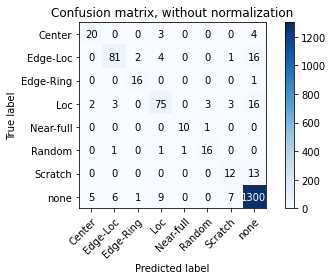

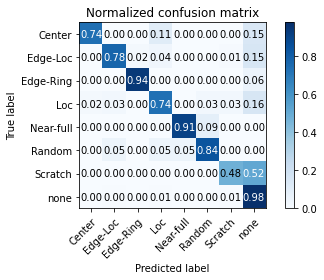

In [73]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix]
plot_confusion_matrix2(y_test_, y_pred_6, classes=labels, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix]
plot_confusion_matrix2(y_test_, y_pred_6, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()

In [68]:
# ResNet50
model5 = ResNet50(input_shape = (32, 32, 3), classes = 8)
model5.summary()
# plot_model(model5, show_shapes=True)

filepath =  os.path.join(dir,'model_output',number, model,'{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
                  LearningRateScheduler(lr_schedule,verbose=1)] 
model5.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['AUC', 'Precision','Recall'])
auto = model5.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), epochs=50, batch_size=500, callbacks=callbacks_list, shuffle=True)

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 34, 34, 3)    0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   1792        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [69]:
y_predict = model5.predict(x_test)
y_pred_5 = np.ones(len(y_predict))
for i in range(len(y_pred_5)):
    y_pred_5[i] = np.argmax(y_predict[i])
print(classification_report(y_test_, y_pred_5, target_names=labels))

              precision    recall  f1-score   support

      Center       0.73      0.81      0.77        27
    Edge-Loc       0.83      0.78      0.80       104
   Edge-Ring       0.74      1.00      0.85        17
         Loc       0.83      0.70      0.76       102
   Near-full       1.00      0.91      0.95        11
      Random       0.73      0.84      0.78        19
     Scratch       0.68      0.52      0.59        25
        none       0.97      0.98      0.98      1328

    accuracy                           0.94      1633
   macro avg       0.81      0.82      0.81      1633
weighted avg       0.94      0.94      0.94      1633



Confusion matrix, without normalization
Normalized confusion matrix


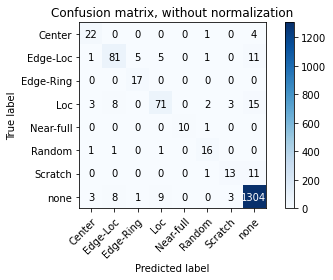

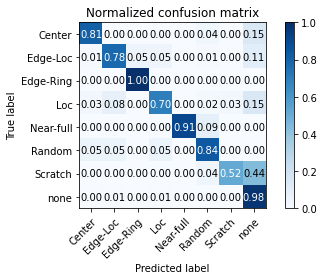

In [70]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix]
plot_confusion_matrix2(y_test_, y_pred_5, classes=labels, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix]
plot_confusion_matrix2(y_test_, y_pred_5, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()

# **Inception-resnet-v2**

In [ ]:
data_name = 'VAE'
number = '2'
batch_sizes = 32
weight_decay = 1e-4
epochs = 50
model = "Inception"
dir = os.path.join(os.getcwd(),data_name)
os.makedirs(os.path.join(dir,'model_output',number,model), exist_ok=True)
os.makedirs(os.path.join(dir,'train_valid_output',number), exist_ok=True)

In [ ]:
def conv2d_bn(x, filters, kernel_size,  strides=1, padding='same', activation='relu', use_bias=False, name=None, weight_decay=weight_decay):
    """Utility function to apply conv + BN.
    # Arguments
        x: input tensor.
        filters: filters in `Conv2D`.
        kernel_size: kernel size as in `Conv2D`.
        padding: padding mode in `Conv2D`.
        activation: activation in `Conv2D`.
        strides: strides in `Conv2D`.
        name: name of the ops; will become `name + '_Activation'`
            for the activation and `name + '_BatchNorm'` for the
            batch norm layer.
    # Returns
        Output tensor after applying `Conv2D` and `BatchNormalization`.
    """
    x = Conv2D(filters,
               kernel_size,
               strides=strides,
               padding=padding,
               use_bias=use_bias,
               name=name)(x)
    if not use_bias:
        bn_axis = 1 if K.image_data_format() == 'channels_first' else 3
        x = BatchNormalization(axis=bn_axis, scale=False)(x)
    if activation is not None:
        x = Activation(activation)(x)
    return x

In [ ]:
def inception_resnet_block(x, scale, block_type, block_idx, activation='relu'):
 
    if block_type == 'block35':
        branch_0 = conv2d_bn(x, 32, 1)
        branch_1 = conv2d_bn(x, 32, 1)
        branch_1 = conv2d_bn(branch_1, 32, 3)
        branch_2 = conv2d_bn(x, 32, 1)
        branch_2 = conv2d_bn(branch_2, 48, 3)
        branch_2 = conv2d_bn(branch_2, 64, 3)
        branches = [branch_0, branch_1, branch_2]
    elif block_type == 'block17':
        branch_0 = conv2d_bn(x, 192, 1)
        branch_1 = conv2d_bn(x, 128, 1)
        branch_1 = conv2d_bn(branch_1, 160, [1, 7])
        branch_1 = conv2d_bn(branch_1, 192, [7, 1])
        branches = [branch_0, branch_1]
    elif block_type == 'block8':
        branch_0 = conv2d_bn(x, 192, 1)
        branch_1 = conv2d_bn(x, 192, 1)
        branch_1 = conv2d_bn(branch_1, 224, [1, 3])
        branch_1 = conv2d_bn(branch_1, 256, [3, 1])
        branches = [branch_0, branch_1]
    else:
        raise ValueError('Unknown Inception-ResNet block type. '
                         'Expects "block35", "block17" or "block8", '
                         'but got: {block_type}'.format(block_type=block_type))

    block_name = '{block_type}_{block_idx}'.format(block_type=block_type, block_idx=block_idx)
    channel_axis = 3
    mixed = Concatenate(axis=channel_axis, name='{block_name}_mixed'.format(block_name=block_name))(branches)
    up = conv2d_bn(mixed,
                   K.int_shape(x)[channel_axis],
                   1,
                   activation=None,
                   use_bias=True,
                   name='{block_name}_conv'.format(block_name=block_name))

    x = Lambda(lambda inputs, scale_: inputs[0] + inputs[1] * scale_,
               output_shape=K.int_shape(x)[1:],
               arguments={'scale_': scale},
               name=block_name)([x, up])
    if activation is not None:
        x = Activation(activation, name='{block_name}_ac'.format(block_name=block_name))(x)

    return x

In [ ]:
def Inception_ResNet_v2(input_shape=None, weight_decay=weight_decay, classes=8, name=None):
 
    img_input = Input(shape=input_shape)


    # Stem block: 35 x 35 x 192
    x = conv2d_bn(img_input, 32, 3, strides=2, padding='valid')
    x = conv2d_bn(x, 32, 3, padding='valid')
    x = conv2d_bn(x, 64, 3)
    x = MaxPooling2D(3, strides=2)(x)
    x = conv2d_bn(x, 80, 1, padding='valid')
    x = conv2d_bn(x, 192, 3, padding='valid')
    x = MaxPooling2D(3, strides=2)(x)

    # Mixed 5b (Inception-A block): 35 x 35 x 320
    branch_0 = conv2d_bn(x, 96, 1)
    branch_1 = conv2d_bn(x, 48, 1)
    branch_1 = conv2d_bn(branch_1, 64, 5)
    branch_2 = conv2d_bn(x, 64, 1)
    branch_2 = conv2d_bn(branch_2, 96, 3)
    branch_2 = conv2d_bn(branch_2, 96, 3)
    branch_pool = AveragePooling2D(3, strides=1, padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    channel_axis = 3
    x = Concatenate(axis=channel_axis, name='mixed_5b')(branches)


    # 10x block35 (Inception-ResNet-A block): 35 x 35 x 320
    for block_idx in range(1, 11):
        x = inception_resnet_block(x,
                                   scale=0.17,
                                   block_type='block35',
                                   block_idx=block_idx)

    # Mixed 6a (Reduction-A block): 17 x 17 x 1088
    branch_0 = conv2d_bn(x, 384, 3, strides=2, padding='same')
    branch_1 = conv2d_bn(x, 256, 1)
    branch_1 = conv2d_bn(branch_1, 256, 3)
    branch_1 = conv2d_bn(branch_1, 384, 3, strides=2, padding='same')
    branch_pool = MaxPooling2D(3, strides=2, padding='same')(x)
    branches = [branch_0, branch_1, branch_pool]
    x = Concatenate(axis=channel_axis, name='mixed_6a')(branches)


    # 20x block17 (Inception-ResNet-B block): 17 x 17 x 1088
    for block_idx in range(1, 21):
        x = inception_resnet_block(x,
                                   scale=0.1,
                                   block_type='block17',
                                   block_idx=block_idx)

    # Mixed 7a (Reduction-B block): 8 x 8 x 2080
    branch_0 = conv2d_bn(x, 256, 1)
    branch_0 = conv2d_bn(branch_0, 384, 3, strides=2, padding='same')
    branch_1 = conv2d_bn(x, 256, 1)
    branch_1 = conv2d_bn(branch_1, 288, 3, strides=2, padding='same')
    branch_2 = conv2d_bn(x, 256, 1)
    branch_2 = conv2d_bn(branch_2, 288, 3)
    branch_2 = conv2d_bn(branch_2, 320, 3, strides=2, padding='same')
    branch_pool = MaxPooling2D(3, strides=2, padding='same')(x)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    x = Concatenate(axis=channel_axis, name='mixed_7a')(branches)


    # 10x block8 (Inception-ResNet-C block): 8 x 8 x 2080
    for block_idx in range(1, 10):
        x = inception_resnet_block(x,
                                   scale=0.2,
                                   block_type='block8',
                                   block_idx=block_idx)
    x = inception_resnet_block(x,
                               scale=1.,
                               activation=None,
                               block_type='block8',
                               block_idx=10)

    # Final convolution block: 8 x 8 x 1536
    x = conv2d_bn(x, 1536, 1, name='conv_7b')

    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(classes, use_bias=False, kernel_regularizer=l2(weight_decay), activation='softmax', name='predictions')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`
    inputs = img_input

    # Create model
    model = Model(inputs, x, name=name)

    return model

In [ ]:
model6 = Inception_ResNet_v2(input_shape = (32, 32, 3), weight_decay=weight_decay, classes=8, name='Inception_ResNet_v2')
model6.summary()
# plot_model(model6, show_shapes=True)
filepath =  os.path.join(dir,'model_output',number, model,'{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
                  LearningRateScheduler(lr_schedule,verbose=1)] 
model6.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['AUC', 'Precision','Recall'])
auto = model6.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), epochs=50, batch_size=300, callbacks=callbacks_list, shuffle=True)

Model: "Inception_ResNet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_527 (Conv2D)             (None, 15, 15, 32)   864         input_36[0][0]                   
__________________________________________________________________________________________________
batch_normalization_435 (BatchN (None, 15, 15, 32)   96          conv2d_527[0][0]                 
__________________________________________________________________________________________________
activation_548 (Activation)     (None, 15, 15, 32)   0           batch_normalization_435[0][0]    
________________________________________________________________________________

In [ ]:
y_predict = model6.predict(x_test)
y_pred_6 = np.ones(len(y_predict))
for i in range(len(y_pred_6)):
    y_pred_6[i] = np.argmax(y_predict[i])
print(classification_report(y_test_, y_pred_6, target_names=labels))

              precision    recall  f1-score   support

      Center       0.68      0.63      0.65        27
    Edge-Loc       0.66      0.62      0.64       104
   Edge-Ring       0.71      0.71      0.71        17
         Loc       0.71      0.59      0.64       102
   Near-full       0.92      1.00      0.96        11
      Random       0.77      0.89      0.83        19
     Scratch       0.35      0.28      0.31        25
        none       0.95      0.97      0.96      1328

    accuracy                           0.91      1633
   macro avg       0.72      0.71      0.71      1633
weighted avg       0.90      0.91      0.90      1633



Confusion matrix, without normalization
Normalized confusion matrix


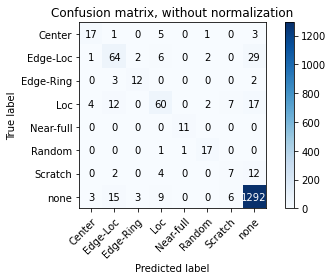

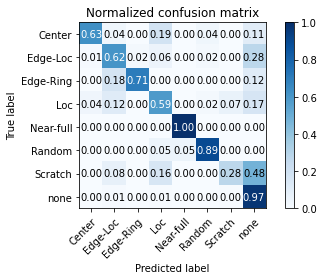

In [ ]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix]
plot_confusion_matrix2(y_test_, y_pred_6, classes=labels, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix]
plot_confusion_matrix2(y_test_, y_pred_6, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()